<a href="https://colab.research.google.com/github/ashwinperti/MNIST_deep1/blob/master/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics


In [ ]:
ckpt = './data/model'
os.makedirs(ckpt, exist_ok=True)

ckpt = os.path.join(ckpt, 'mnist_nn.pth')
print(ckpt)

./data/model/mnist_nn.pth


In [ ]:
epochs=0
# https://en.wikipedia.org/wiki/Standard_score
mean = (0.5,)
std = (0.5,)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


In [ ]:
ds_train = torchvision.datasets.MNIST(root='data', train=True, transform=transform, download=True)
ds_test = torchvision.datasets.MNIST(root='data', train=False, transform=transform, download=True)


In [ ]:
print(len(ds_train))
print(len(ds_test))

60000
10000


In [ ]:
loader_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

print(len(loader_train), len(loader_test))

1875 313


In [ ]:
images, labels = next(iter(loader_train))

In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [ ]:
img = images[0]
label = labels[0]
print(img.shape)
print(label)


torch.Size([1, 28, 28])
tensor(7)


In [ ]:
img = img.squeeze()
print(img.shape)


torch.Size([28, 28])


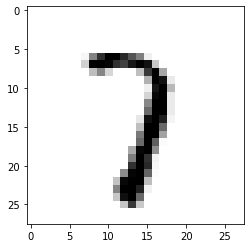

In [ ]:
plt.imshow(img, cmap='gray_r');

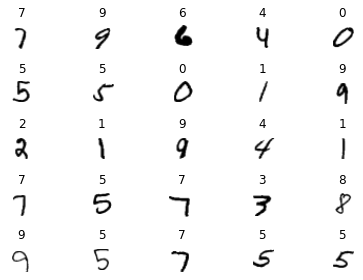

In [ ]:
fig = plt.figure()

for idx in range(25):
    img = images[idx].squeeze()
    label = labels[idx].numpy()
    
    plt.subplot(5, 5, idx+1)
    plt.imshow(img, cmap='gray_r')
    plt.title(label)
    plt.axis('off')
fig.tight_layout()


Activation Function

    Activation functions introduce non-linearity
    Sigmoid and tanh are other activation functions, however, these lead to vanishing gradients
    ReLU is most popular activation function since 2017, f(x)=max(0,x)

ReLU is not differentiable at x=0
and that was the reason it was not used earlier, however, it was observed that ReLU is now observed that it is better that other activation function.
During backpropogation, derivative is considered 0. Thus, for negative values, slope is 0 and for positive value, slope is 1.
ReLU may also have problems due to negative value mapped to zero, but other variants like Leaky ReLU may be explored

In [ ]:
def rectified_linear_function(x):
	return max(0.0, x)


Computing Output size in the Convolutional Layer:

    input−kernelsize+2∗Paddingstride+1

nn.Conv2d(1,32,3,1)
implies in_channels, out_channels, kernel_size, stride
Input is (−1,1,28,28)
, -1 is for batch size and 1, 28, 28 is for gray scale with 28x28
nn.Conv2d(1,32,3,1)
implies that we have input channels as 1 and we need output channels as 32 using kernel size as 3 and stride as 1
Irrespective of other parameters output will have first two values −1,32
and we can find other values as below
Output from this should be 28−3+2∗01+1=26
, this implies output will have (−1,32,26,26)
nn.Conv2d(32,64,3,1)
With input as (−1,32,26,26)

    (−1, 64, , )

26−3+2∗01+1=24
(−1,64,24,24)

nn.MaxPool2d(2,2)
With input (−1,64,24,24)

    (−1, 64, , )

24−2+2∗02+1=12
(−1,64,12,12)

$ nn.Linear(641212, 128) $
nn.Linear(128,10)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # -1,1,28,28
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # -1,32,26,26
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # -1,64,24,24
        self.pool = nn.MaxPool2d(2, 2) # -1,64,12,12
        self.drop1 = nn.Dropout2d(0.25)
        self.drop2 = nn.Dropout2d(0.50)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)  # https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599/2
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.pool(x)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.drop2(x)
        
        x = self.fc2(x)
        
        return x
    
model = Net()


In [ ]:
for param in model.parameters():
    print(param.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 9216])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Train One Epoch
def train(loader):
    running_loss = 0.0
    running_acc = 0.0
    
    for data in loader:
        inputs, labels = data
        
        #inputs = inputs.view(inputs.shape[0], -1) # Flatten the input
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
        
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # return python scalar from loss which is tensor with gradient enabled
        
        y_true = labels.numpy()
        ps = torch.nn.functional.softmax(outputs, dim=1)
        pred = ps.max(1, keepdim=True) # tuple of prob and index of max
        y_pred = pred[1] # index
        y_pred = y_pred.numpy()
        
        acc = metrics.accuracy_score(y_true, y_pred)
        
        running_acc += acc
        
    running_loss /= len(loader)
    running_acc /= len(loader)
    return running_loss, running_acc

#train(loader_train)

In [ ]:
# Test One Epoch
def test(loader):
    running_loss = 0.0
    running_acc = 0.0
    
    for data in loader:
        inputs, labels = data
        
        #inputs = inputs.view(inputs.shape[0], -1) # Flatten the input
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
        
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        running_loss += loss.item() # return python scalar from loss which is tensor with gradient enabled
        
        y_true = labels.numpy()
        ps = torch.nn.functional.softmax(outputs, dim=1)
        pred = ps.max(1, keepdim=True) # tuple of prob and index of max
        y_pred = pred[1] # index
        y_pred = y_pred.numpy()
        
        acc = metrics.accuracy_score(y_true, y_pred)
        
        running_acc += acc
        
    running_loss /= len(loader)
    running_acc /= len(loader)
    
    return running_loss, running_acc

#train(loader_test)

In [ ]:
losses = {'train': [], 'test': []}
acces = {'train': [], 'test': []}

for epoch in range(epochs):
    loss, acc = train(loader_train)
    losses['train'].append(loss)
    acces['train'].append(acc)
    
    print(f'Train Epoch: {epoch+1:2d}   Loss: {loss:.3f}   Acc: {acc:.3f}')
    
    loss, acc = test(loader_test)
    losses['test'].append(loss)
    acces['test'].append(acc)
    
    print(f'Test  Epoch: {epoch+1:2d}   Loss: {loss:.3f}   Acc: {acc:.3f}')
    
    print()
    #break

In [ ]:
if epochs > 0:
    ckpt_dict = {}
    ckpt_dict['state_dict'] = model.state_dict()
    ckpt_dict['losses'] = losses
    ckpt_dict['acces'] = acces
    torch.save(ckpt_dict, ckpt)

In [ ]:
ckpt_dict = torch.load(ckpt)

model = ckpt_dict['state_dict']
losses = ckpt_dict['losses']
acces = ckpt_dict['acces']

FileNotFoundError: ignored

In [ ]:
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend();

plt.plot(acces['train']);
plt.plot(acces['test']);


In [ ]:
print(losses)